In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *

In [2]:
experiment=3
func='rosenbrock'
path = Path(f'../../data/results2/exp{experiment}/{func}')

In [3]:
D = 30
frequency = 1#00_000
max_times = 100
total_generations = max_times * frequency*100000 + 1000000

In [4]:
# funcs
if func=='sphere':
    if experiment==1 or experiment==2:
        ab = pd.read_csv(path/'dC_01.csv')['b'].values
        def fitness_func(indiv, b, t): return (indiv.data**2).sum()
        def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)

    elif experiment==3:
        ab=[]
        # experiment 3: dynamic fitness function (linear)
        def fitness_func(indiv, b, t): return ((indiv.data +0.1*t)**2).sum()
        def constraint_func(indiv, b, t): return 0

    else:
        ab=pd.read_csv(path/'dC_01.csv')['b'].values
    # experiment 5: dynamic fitness function (x-sin(pi/2*t))^2 with random changes on peak of sin
        def fitness_func(indiv, b, t): return ((indiv.data-b[t]*np.sin(np.pi/2*t))**2).sum()
        def constraint_func(indiv, b, t): return 0
    
elif func=='rastrigin':
    if experiment==1 or experiment==2:
        ab = pd.read_csv(path/'dC_01.csv')['b'].values
        def fitness_func(indiv, b, t): return 10*D+((indiv.data**2)-10*np.cos(2*np.pi*indiv.data)).sum()
        def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)

    elif experiment==3:
        ab=[]
        # experiment 3: dynamic fitness function (linear)
        def fitness_func(indiv, b, t): return 10*D+(((indiv.data+0.1*t)**2)-10*np.cos(2*np.pi*indiv.data)).sum()
        def constraint_func(indiv, b, t): return 0

    else:
        ab=pd.read_csv(path/'dC_01.csv')['b'].values
    # experiment 5: dynamic fitness function (x-sin(pi/2*t))^2 with random changes on peak of sin
        def fitness_func(indiv, b, t): return 10*D+(((indiv.data-b[t]*np.sin(np.pi/2*t))**2)-10*np.cos(2*np.pi*indiv.data)).sum()
        def constraint_func(indiv, b, t): return 0

elif func=='rosenbrock':
    if experiment==1 or experiment==2:
        ab = pd.read_csv(path/'dC_01.csv')['b'].values
        def fitness_func(indiv, b, t): return ((100 * (indiv.data[1:] - indiv.data[:-1]**2)**2) + (1-indiv.data[:-1])**2).sum()
        def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)

    elif experiment==3:
        ab=[]
        # experiment 3: dynamic fitness function (linear)
        def fitness_func(indiv, b, t): return (100 * (((indiv.data[1:]+0.1*t) - (indiv.data[:-1]+0.1*t)**2)**2) + (1-indiv.data[:-1]-0.1*t)**2).sum()
        def constraint_func(indiv, b, t): return 0

    else:
        ab=pd.read_csv(path/'dC_01.csv')['b'].values
    # experiment 5: dynamic fitness function (x-sin(pi/2*t))^2 with random changes on peak of sin
        def fitness_func(indiv, b, t): return (((100 * ((indiv.data[1:]-b[t]*np.sin(np.pi/2*t)) - (indiv.data[:-1]-b[t]*np.sin(np.pi/2*t))**2)**2) + (1-indiv.data[:-1]+b[t]*np.sin(np.pi/2*t))**2)).sum()
        def constraint_func(indiv, b, t): return 0

In [5]:
# population = Population.new_random(dimension=D)

# opt = Optimization(population, fitness_func, constraint_func, fitness_params=ab, constraint_params=[ab],
#                    max_times=max_times, frequency=frequency, callbacks=[OnChangeRestartPopulation])
# opt.state_dict

In [6]:
population = Population.new_random(dimension=D)
save_bests = partial(SaveBestIndividuals, out_path='test.npy')

opt = Optimization(population, fitness_func, constraint_func, fitness_params=ab, constraint_params=[ab],
                   max_times=max_times, frequency=frequency,
                   callbacks=[OnChangeRestartPopulation, save_bests])
opt.state_dict

{'gen': 0, 'evals': 0, 'time': 0, 'time_evals': 0, 'best': None}

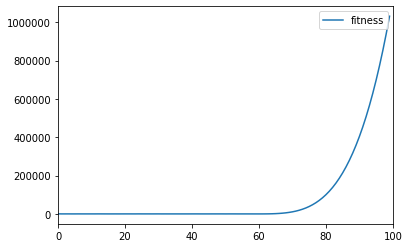

Run cancelled: `max_time` reached.


TypeError: on_run_end() got an unexpected keyword argument 'gen'

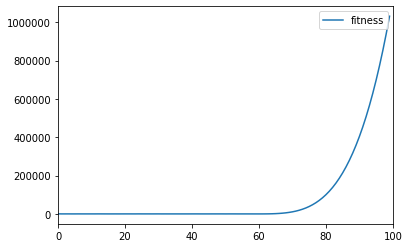

In [7]:
opt.run(total_generations, update_each=1)

In [8]:
%debug

> /home/renato/github/DENN/denn/callbacks.py(57)_call_and_update()
     55     def _call_and_update(self, cb:Callback, cb_name:str, **kwargs:Any)->None:
     56         "Call `cb_name` on `cb` and update the inner state."
---> 57         new = ifnone(getattr(cb, f'on_{cb_name}')(**self.state_dict, **kwargs), dict())
     58         for k,v in new.items():
     59             if k not in self.state_dict:

ipdb> kwargs.keys()
dict_keys([])
ipdb> self
CallbackHandler(optim=Optimization(population=Population(n=20, dimension=30), get_fitness=<function fitness_func at 0x7efff968a830>, get_constraints=[<function constraint_func at 0x7efff968a8c0>], fitness_params=[], constraint_params=[[]], max_times=100, frequency=1, CR=0.3, beta_min=0.2, beta_max=0.8, max_evals=None, time_change_detect=True, time_change_pcts=(0.0, 0.5), callbacks=[<denn.callbacks.Recorder object at 0x7efff9b2acd0>, <denn.callbacks.OnChangeRestartPopulation object at 0x7efff96cf850>, <denn.callbacks.SaveBestIndividuals objec

In [ ]:
opt.recorder.plot();

In [87]:
df = pd.DataFrame({'fitness':opt.recorder.best_times_fitness, 'sum_constraints':opt.recorder.best_times_constraints})
df.head()

,fitness,sum_constraints
0,25.447980,0
1,24.335278,0
2,25.328361,0
3,24.566960,0
4,26.662802,0


In [88]:
path.mkdir(parents=True, exist_ok=True)
df.to_csv(path/'best_known.csv', index=False)